# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### **Tecnológico de Monterrey**

### **Prof. Dra. Grettel Barceló Alonso**

### EQUIPO 20

- ### OSCAR MAURICIO BECERRA ALEGRÍA | A01795611

- ### VÍCTOR DANIEL BOHÓRQUEZ TORIBIO | A01794554

- ### ALAN JASSO ARENAS | A01383272



## **Modelos alternativos de Machine Learning**
### **Proyecto de análisis y pronóstico epidemiológico de enfermedades neurológicas y trastornos mentales en México, con énfasis en la enfermedad de Parkinson (EP) durante 2014–2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Leemos los datos
df = pd.read_csv('dataset_ml.csv')

# Dividimos en X y Y

X = df.drop('Nuevos_Casos', axis=1)
y = df['Nuevos_Casos']


In [3]:
# Separamos nuestros datos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Definimos nuestra función para calcular la métrica sMAPE

In [4]:
def sMAPE(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

## Definimos nuestra función para calcular la métrica MASE

In [5]:
def MASE(train, actual, forecast):
    n = train.shape[0]
    d = np.abs(np.diff(train)).sum()/(n-1)
    errors = np.abs(actual - forecast)
    return errors.mean()/d

## Definimos la función para calcular el error relativo

In [6]:
def relative(mae, y_avg):
    rel = (mae / y_avg) * 100
    return rel

# Random Forest

In [7]:
# Entrenamos nuestro modelo de regresión
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, criterion='poisson', random_state=42, n_jobs=-1, min_samples_leaf=8)
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'poisson'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Métricas del modelo

In [8]:
y_pred = rf_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)

Relative Error Percentage:  9.073037345122012  %
Mean Absolute Error (MAE):  12.369311260593298
Symetric Mean Absolute Percentage Error (sMAPE):  9.636924233476902  %
Mean Absolute Scaled Error (MASE):  0.2876876811080023
Mean Squared Error (MSE):  246.18939232174773
R-squared (R²):  0.8390566323759389
Root Mean Squared Error (RMSE):  15.690423586434743


## Importancia del modelo

In [9]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

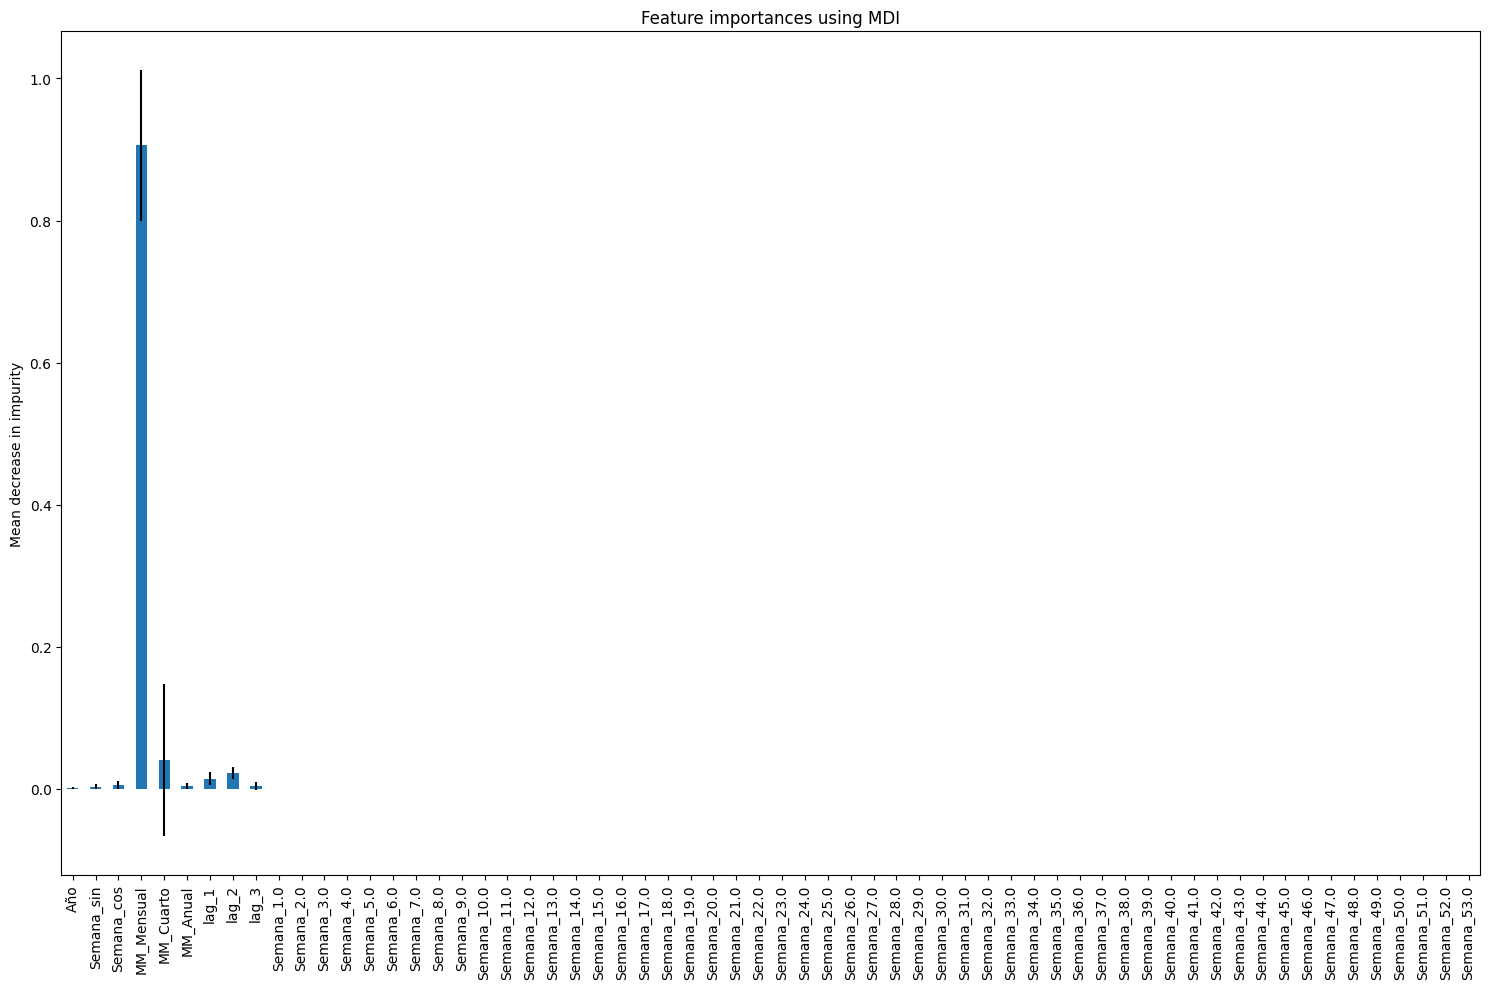

In [10]:
forest_importances = pd.Series(importances, index=list(X.columns))

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Ajuste del modelo

In [11]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

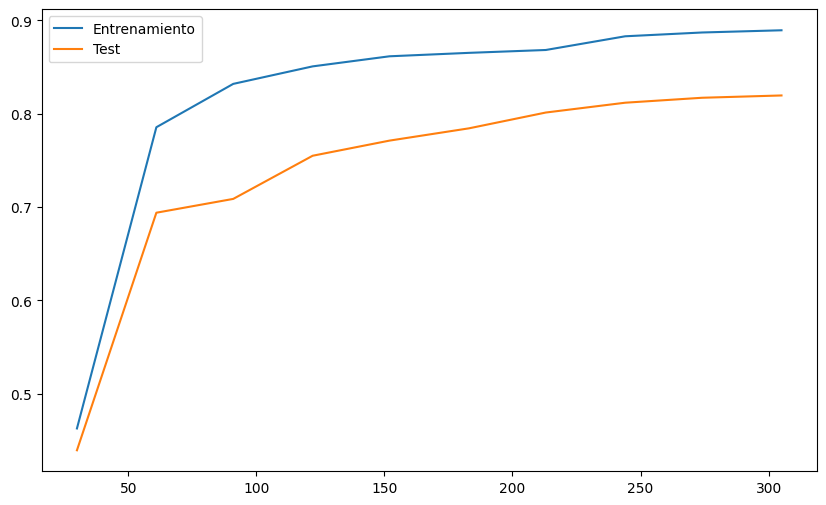

In [12]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

# XGBOOST

In [13]:
xgb_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 150, seed = 42, learning_rate=0.1, gamma=0.1, max_depth=5, n_jobs=-1)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Métricas del modelo

In [14]:
y_pred = xgb_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)

Relative Error Percentage:  8.800335541141322  %
Mean Absolute Error (MAE):  11.997535705566406
Symetric Mean Absolute Percentage Error (sMAPE):  9.243215225138053  %
Mean Absolute Scaled Error (MASE):  0.2790408347837341
Mean Squared Error (MSE):  232.6888885498047
R-squared (R²):  0.8478824496269226
Root Mean Squared Error (RMSE):  15.25414332402199


## Importancia del modelo

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

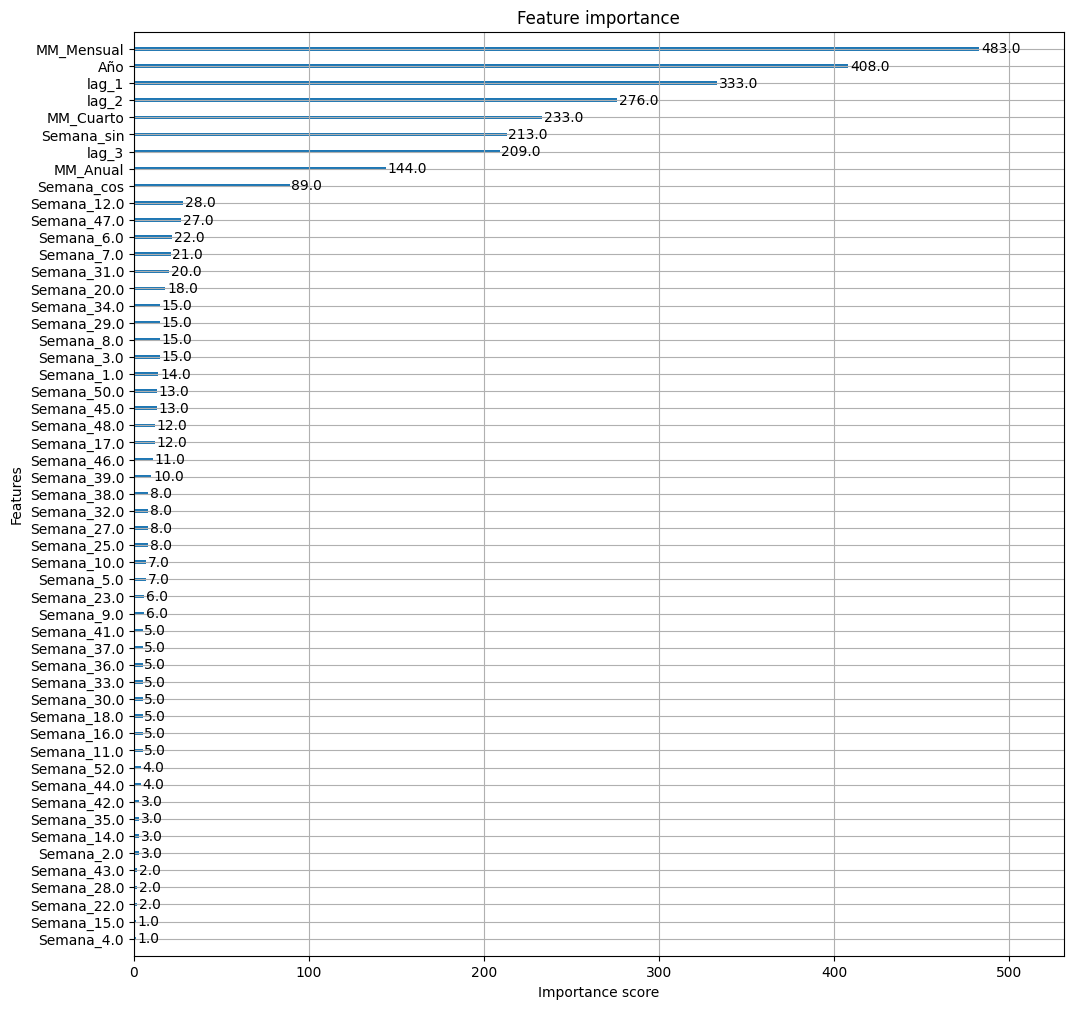

In [15]:
plt.rcParams["figure.figsize"] = (12, 12)
plot_importance(xgb_model, )

## Ajuste del modelo

In [16]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

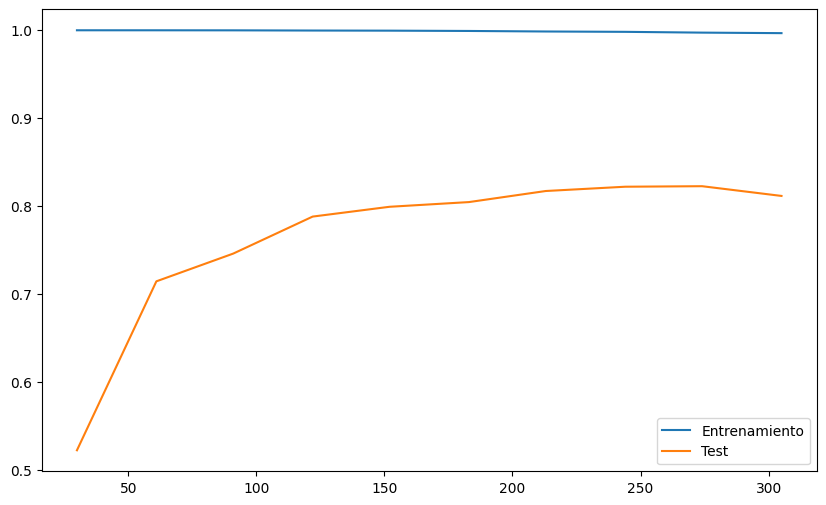

In [17]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

# LigthGBM

Para este modelo utilizaremos un test de validación, por lo tanto vamos a dividir nuestro set de entrenamiento para tener nuestro set adicional.

In [18]:
# Separamos nuestros datos de entrenamiento y validación
X_train_gbm, X_val, y_train_gbm, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

In [19]:
train_data = lgb.Dataset(X_train_gbm, label=y_train_gbm)
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [20]:
params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'feature_fraction': 0.8
}

num_round = 200
lgbm_model = lgb.train(params, train_data, num_round, valid_sets=[
                test_data], callbacks=[lgb.early_stopping(stopping_rounds=12)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 9
[LightGBM] [Info] Start training from score 144.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 12 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

## Métricas del modelo

In [21]:
y_pred = lgbm_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)

Relative Error Percentage:  9.429656620142806  %
Mean Absolute Error (MAE):  12.855491868747734
Symetric Mean Absolute Percentage Error (sMAPE):  9.8817747442962  %
Mean Absolute Scaled Error (MASE):  0.2989953577290302
Mean Squared Error (MSE):  280.29506743873395
R-squared (R²):  0.8167604556127818
Root Mean Squared Error (RMSE):  16.74201503519615


## Importancia del modelo

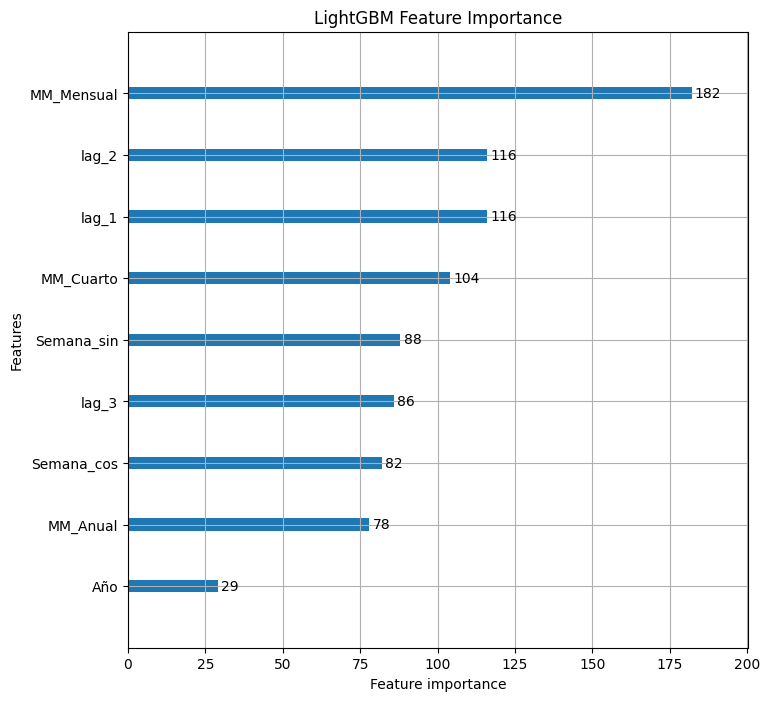

In [22]:
lgb.plot_importance(lgbm_model, importance_type="split", figsize=(8,8), title="LightGBM Feature Importance")
plt.show()

# Hist Gradient Booster

In [23]:
# Entrenamos nuestro modelo de regresión
hgb_model = HistGradientBoostingRegressor(loss="gamma", n_iter_no_change=4, learning_rate=0.1, max_iter=200, max_depth=20)
hgb_model.fit(X_train, y_train)

,loss,'gamma'
,quantile,None
,learning_rate,0.1
,max_iter,200
,max_leaf_nodes,31
,max_depth,20
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


## Métricas del modelo

In [24]:
y_pred = hgb_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)

Relative Error Percentage:  8.401710162158107  %
Mean Absolute Error (MAE):  11.454087993244768
Symetric Mean Absolute Percentage Error (sMAPE):  8.871885715252548  %
Mean Absolute Scaled Error (MASE):  0.26640125262928693
Mean Squared Error (MSE):  226.68483769128719
R-squared (R²):  0.8518075014390999
Root Mean Squared Error (RMSE):  15.056056511958474


## Importancia del modelo

In [25]:
importance = permutation_importance(hgb_model, X_train, y_train, n_repeats=10, random_state=42)

In [26]:
importances = importance.importances_std
indices = np.argsort(importances)[::-1]

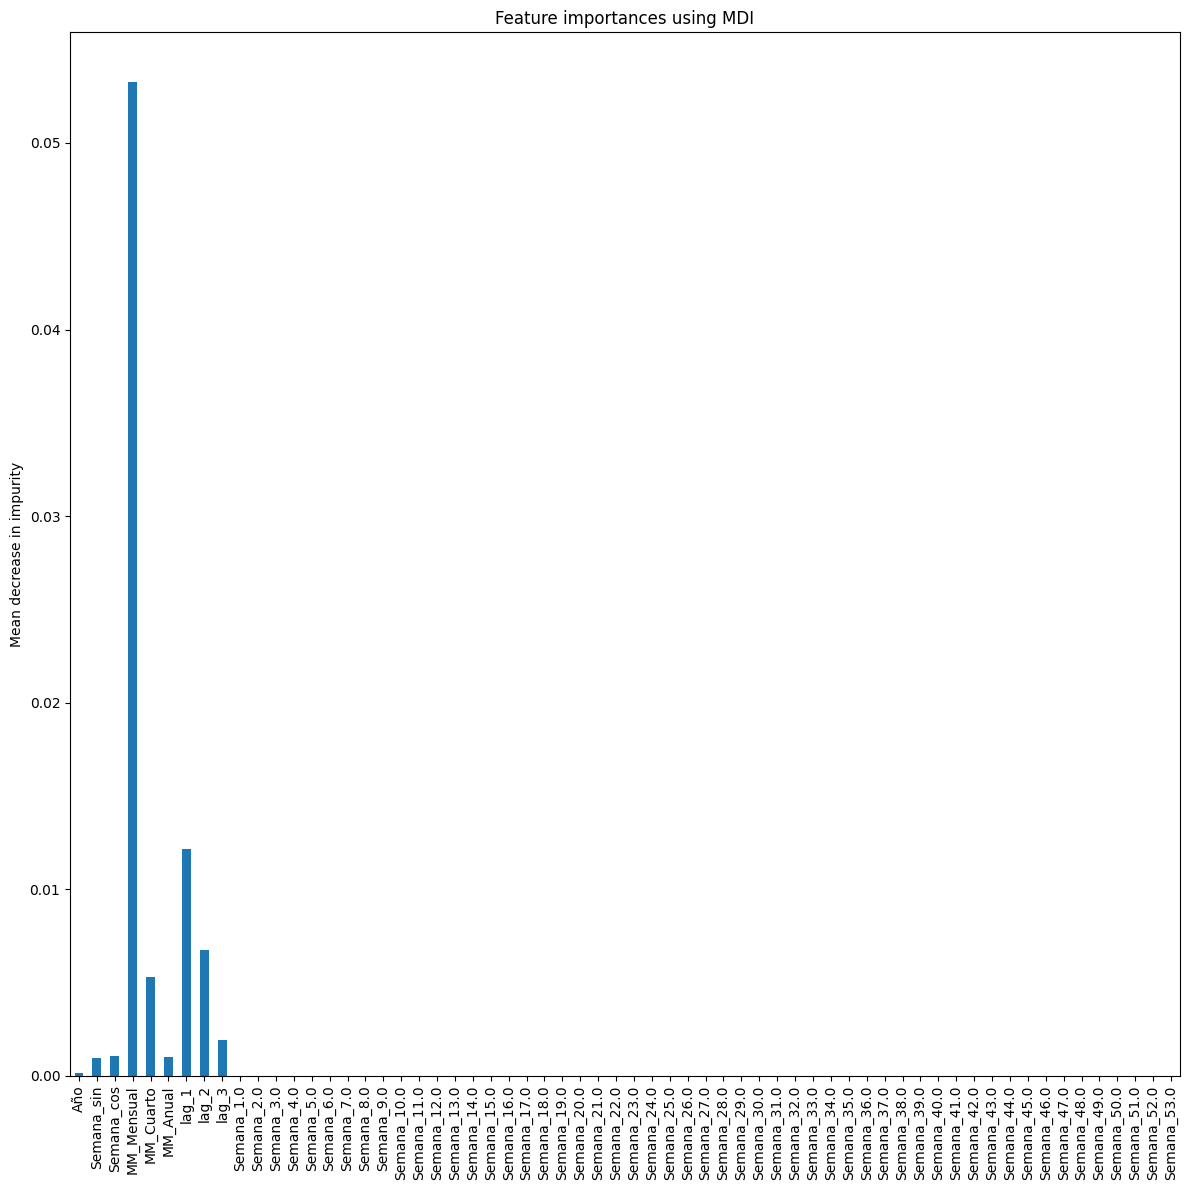

In [27]:
forest_importances = pd.Series(importances, index=list(X.columns))

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Ajuste del modelo

In [28]:
train_sizes, train_scores, test_scores = learning_curve(hgb_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

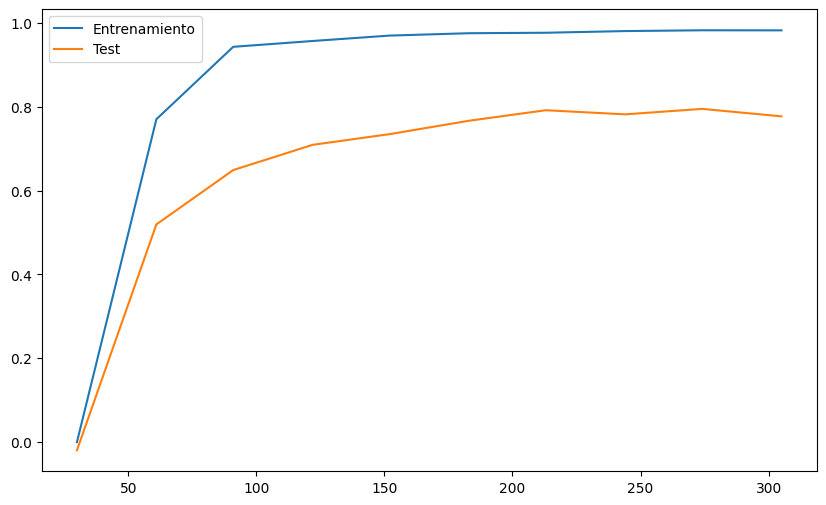

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

# Elección del mejor modelo

## Comparación de Modelos

Durante el entrenamiento de nuestros modelos se utilizaron distintas métricas, las que se considerarán para analizar nuestros modelos y para ser capaces de comparar directamente estos modelos con los modelos de series de tiempo, serán: sMAPE, MAE y MASE, de manera específica para comparar estos modelos entre sí, se utilizará R² para analizar la explicabilidad de la varianza de los modelos.

### Tabla Comparativa

| Modelo              | sMAPE      | MAE       | MASE     | R²       | **Error Relativo** |
|---------------------|------------|-----------|----------|----------|--------------------|
| Random Forest       | 9.636924 % | 12.369311 | 0.287687 | 0.839056 | 9.07303734512201 % |
| XGBoost             | 9.243215 % | 11.997535 | 0.279040 | 0.847882 | 8.80033554114132 % |
| LightGBM            | 9.881774 % | 12.855491 | 0.298995 | 0.816770 | 9.42965662014280 % |
| Hist Gradient Boost | 8.871885 % | 11.454087 | 0.266401 | 0.851807 | 8.40171016215810 % |

Vemos que el modelo de Random Forest y LigthGBM tienen una explicabilidad buena, en el caso de Random Forest este modelo no presenta un subentrenamiento ni sobreentrenamiento, sin embargo, estos modelos no son los mejores presentados.

En el Caso de XGBoost, el modelo es el único que le da importancia a las características de semana, además al ver su curva de aprendizaje notamos un poco de subentrenamiento, sin embargo, tiene muy buenos resultados, los errores son los segundos más bajos en relación a los errores, y su explicabilidad es ligeramente menor a la del mejor modelo.

## Elección del modelo

El mejor modelo, con lo errores más bajos y la explicabilidad más alta, además que su curva de aprendizaje nos muestra que no presenta subentrenamiento ni sobreentrenamiento, es el modelo **Hist Gradient Boost**